# Evaluating code-completion models on code samples

## load data
I will use files with code from my [repository](https://github.com/SzymonKozl/irio_alerting_platform) alerting service designed to run on GCP created as a team project for uni course

In [1]:
!git clone https://github.com/SzymonKozl/irio_alerting_platform

Cloning into 'irio_alerting_platform'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 787 (delta 129), reused 129 (delta 72), pack-reused 532 (from 1)
Receiving objects: 100% (787/787), 135.90 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (390/390), done.


In [1]:
import os

In [2]:
# constants
MAX_CONTEXT_LEN = 8192 # max context length for tiny_starcoder
DS_DIR = 'irio_alerting_platform'
FILE_EXTENSIONS = ['.py']

## Dataset preparation
### You may skip this section if the `samples.json` file is already present
Dataset will be constructed by selecting single non-empty line from each file and marking its non-empty suffix as completion target. This generation approach aims in simulating code completion up to the end of line. Due to the low number of files available, I have decided to choose two samples from each file instead of one.

In [3]:
from typing import List
from random import choice, randrange


def traverse_repo_rec(path):
    res = []
    for entry in os.listdir(path):
        if os.path.isdir(os.path.join(path, entry)):
            res.extend(traverse_repo_rec(os.path.join(path, entry)))
        else:
            if os.path.splitext(entry)[1] in FILE_EXTENSIONS:
                with open(os.path.join(path, entry), 'r') as f:
                    res.append(f.readlines())
    return res

def content_to_sample(file_content: List[str], no: int = 1) -> List[dict]:
    res = []
    pool = [i for i, line in enumerate(file_content) if not line.isspace() and len(line) > 0]
    for _ in range(no):
        assert len(pool) > 0
        ix = choice(pool)
        pool.remove(ix)
        line_split = randrange(0, max(1, len(file_content[ix]) // 2))
        prefix = ''.join(file_content[:ix]) + file_content[ix][:line_split]
        missing = file_content[ix][line_split:]
        suffix = ''.join(file_content[ix + 1:])
        res.append({
            'prefix': prefix,
            'suffix': suffix,
            'missing': missing,
        })
    return res

contents = traverse_repo_rec(DS_DIR)
samples = [x for c in contents for x in content_to_sample(c, 2)]
from json import dump
with open('samples.json', 'w') as f:
    dump(samples, f)

In [4]:
from json import load
with open('samples.json', 'r') as f:
    samples = load(f)

## Model evaluation
I have chosen to use chrf metric mor evaluation. I will compare it with [CodeBleu](https://github.com/k4black/codebleu), a modification of bleu score adapted for code generation tasks. An interesting option would be to use semantic-based evaluation, for example pass@k considered [here](https://arxiv.org/pdf/2107.03374). However, due to the lack of the complete unit test coverage to my code I will not explore that further.

In [5]:
from eval_model import eval_model
score, generated = eval_model('bigcode/tiny_starcoder_py', samples)
print(score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad

{'bleu': {'codebleu': 0.1469243646054088, 'ngram_match_score': 0.04630156709357864, 'weighted_ngram_match_score': 0.05615685189205753, 'syntax_match_score': 0.2303370786516854, 'dataflow_match_score': 0.2549019607843137}, 'chrf': 38.86010962918205}


    As we are dealing with line completion task now, we can measure the model's score when we cut each prediction after the first newline character

In [6]:
score, generated = eval_model('bigcode/tiny_starcoder_py', samples, first_line_only=True)
print(score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

{'bleu': {'codebleu': 0.42650865557794226, 'ngram_match_score': 0.1299869253996847, 'weighted_ngram_match_score': 0.13639252449829128, 'syntax_match_score': 0.4396551724137931, 'dataflow_match_score': 1.0}, 'chrf': 47.4619419561463}


Single sample + prediction

In [11]:
ix=11
print(samples[ix]['prefix'])
print("="*20)
print(samples[ix]['missing'])
print("="*20)
print(samples[ix]['suffix'])

import sys
from pathlib import Path

server_dir = Path(__file__).parent.parent.parent / "server"
sys.path.append(str(server_dir))

import pytest
import pytest_postgresql
from datetime import datetime
import db_access
from common import JobData, NotificationData


def setup_db(conn):
    setup_file = server_dir / "db_migrations/V2__setup.sql"
    with open(setup_file, 'r') as file:
        sql_script = file.read()
    
    cursor = conn.cursor()
    cursor.execute(sql_script)
    conn.commit()


EXAMPLE_JOBS = [
    JobData(1, "mail1@example.com", "mail2@example.com", "http://example.com", 10, 11, 12, True),
    JobData(2, "mail3@example.com", "mail2@example.com", "http://ugabuga.com", 100, 100, 200, True),
    JobData(3, "mail4@example.com", "mail5@example.com", "http://service.com", 1000, 10, 100, False)
]

EXAMPLE_JOBS_PODS = [0, 1, 1]


def insert_example_jobs(conn):
    cursor = conn.cursor()
    for job, pod in zip(EXAMPLE_JOBS, EXAMPLE_JOBS_PODS):
        cursor.execute("INSERT I

In [12]:
print(generated[ix])

ert_jobs(postgresql)



In [29]:
import evaluate
import pandas as pd
from codebleu import calc_codebleu
pd.set_option('display.max_rows', None)
metric_chrf = evaluate.load('chrf')
metric_bleu = evaluate.load('bleu')
data = {
    "prefix": [],
    "suffix": [],
    "missing": [],
    "predictions": [],
    "chrf": [],
    "codebleu": [],
    "exact_match": []
}
for s, pred in zip(samples, generated):
    pref = s['prefix'].split('\n')[-1]
    for pref_cand in reversed(s['prefix'].split('\n')[:-1]):
        if pref:
            break
        pref = pref_cand
    data["prefix"].append(pref)
    suff = s['suffix'].split('\n')[0]
    for suff_cand in s['suffix'].split('\n')[1:]:
        if suff:
            break
        suff = suff_cand
    data["suffix"].append(suff)
    data["missing"].append(s['missing'])
    data["predictions"].append(pred)
    data["chrf"].append(metric_chrf.compute(predictions=[pred], references=[[s['missing']]])['score'])
    data["codebleu"].append(calc_codebleu([pred], [s['missing']], lang='python')['codebleu'])
    data["exact_match"].append(float(pred == s['missing']))
frame = pd.DataFrame(data)
frame.to_csv('predictions.csv', index=False)

In [30]:
frame = pd.read_csv('predictions.csv')
frame

,prefix,suffix,missing,predictions,chrf,codebleu,exact_match
0,,sleep(5),try:\n,mock_service.respond_404()\n,2.976190,0.250000,0.0
1,,"signal.signal(signal.SIGCHLD, handle_c...",sleep(1)\n,sleep(3)\n,61.488095,0.500000,0.0
2,log(,"def log_net(lvl_callable, message, service, po...","message, ""DEBUG"")\n","message, ""DEBUG"")\n",100.000000,0.641929,1.0
3,"lvl_callable(f""com",NaN,munication with {service} at {port}: {message}...,"{service} {port}"", message)\n",40.019226,0.410206,0.0
4,def,resp = requests.get(link),"confirm_alert(self, link: str) -> bool:\n",def close(self):\n,12.746639,0.250000,0.0
5,,"port=DB_PORT,","host=DB_HOST,\n","host=DB_HOST,\n",100.000000,0.555394,0.0
6,response_,"response_modes = {'normal', 'timeout', '404'}",mode = 'normal'\n,= web.Response(text='hello world')\n,12.031298,0.334655,0.0
7,r,"signal.signal(signal.SIGTERM, handle_SIGINT)",aise GracefulExit()\n,= web.Response()\n,6.821821,0.291667,0.0
8,,payload = example_payload.copy(),test_client = await aiohttp_client(setup_a...,test_client = await aiohttp_client(setup_ap...,100.000000,1.000000,0.0
9,import,import asyncio,pytest\n,aiohttp\n,8.064516,0.500000,0.0


In this case, the CodeBleu might not be as accurate as in whole corpus case as we get 0 as `dataflow_match_score`. However, we will check how the scores correlate with manual reviews anyway.

## Manual review
I will grant each prediction a score from `[0-10]` range.

In [31]:
frame['manual_score'] = [3, 9, 10, 6, 1, 10, 5, 4, 10, 6] + [4, 3, 2, 5, 4, 0, 3, 5, 6, 10] + [10, 4, 5, 5]
frame[['manual_score', 'codebleu', 'chrf']]

,manual_score,codebleu,chrf
0,3,0.250000,2.976190
1,9,0.500000,61.488095
2,10,0.641929,100.000000
3,6,0.410206,40.019226
4,1,0.250000,12.746639
5,10,0.555394,100.000000
6,5,0.334655,12.031298
7,4,0.291667,6.821821
8,10,1.000000,100.000000
9,6,0.500000,8.064516


### Correlations between metrics

In [32]:
print(frame[["manual_score", "codebleu", "chrf", "exact_match"]].corr())

              manual_score  codebleu      chrf  exact_match
manual_score      1.000000  0.779337  0.762098     0.326336
codebleu          0.779337  1.000000  0.853735     0.228637
chrf              0.762098  0.853735  1.000000     0.298348
exact_match       0.326336  0.228637  0.298348     1.000000


The general correlation between human judgement and chrf and codebleu is high. Moreover, these two metrics correlate with each other with coefficient around `0.8`

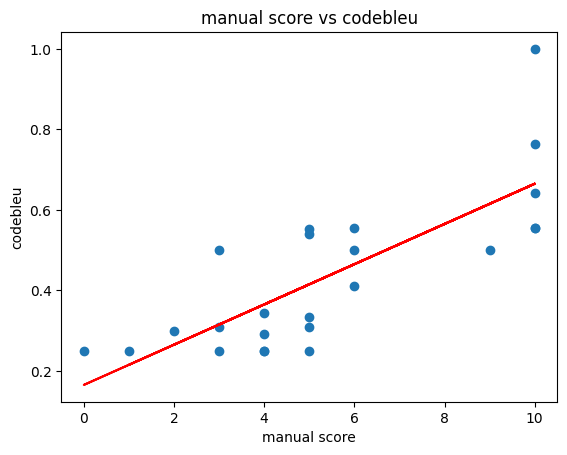

In [33]:
from matplotlib import pyplot as plt
import numpy as np
plt.scatter(frame['manual_score'], frame['codebleu'])
plt.title('manual score vs codebleu')
plt.xlabel('manual score')
plt.ylabel('codebleu')
coeffs = np.polyfit(frame['manual_score'], frame['codebleu'], 1)
m, b = coeffs

codebleu_pred = m * frame['manual_score'] + b
se_codebleu = (codebleu_pred - frame['codebleu']) ** 2
plt.plot(frame['manual_score'], codebleu_pred, color='red')
plt.show()

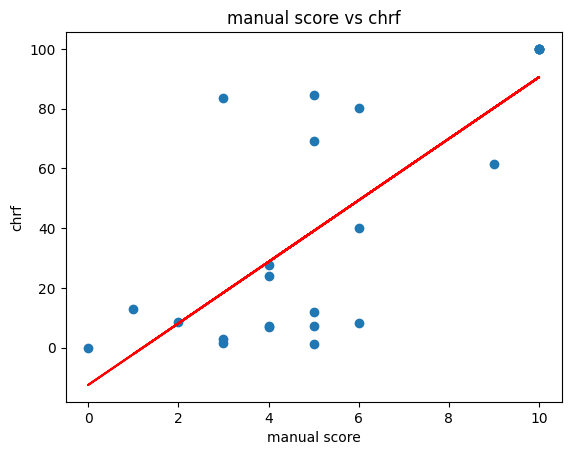

In [34]:
plt.scatter(frame['manual_score'], frame['chrf'])
plt.title('manual score vs chrf')
plt.xlabel('manual score')
plt.ylabel('chrf')
coeffs = np.polyfit(frame['manual_score'], frame['chrf'], 1)
m, b = coeffs

chrf_pred = m * frame['manual_score'] + b
se_chrf = (chrf_pred - frame['chrf']) ** 2
plt.plot(frame['manual_score'], chrf_pred, color='red')
plt.show()

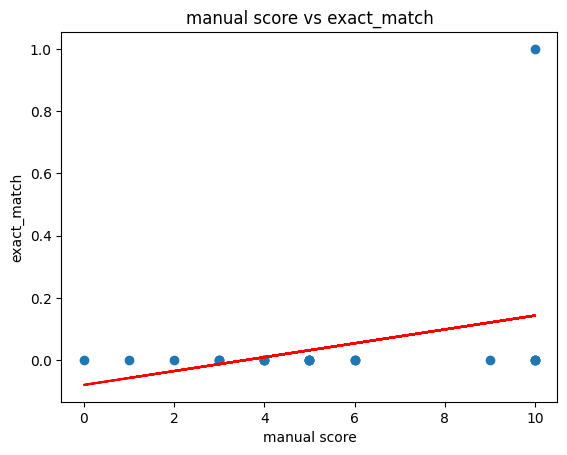

In [35]:
plt.scatter(frame['manual_score'], frame['exact_match'])
plt.title('manual score vs exact_match')
plt.xlabel('manual score')
plt.ylabel('exact_match')
coeffs = np.polyfit(frame['manual_score'], frame['exact_match'], 1)
m, b = coeffs

exact_match_pred = m * frame['manual_score'] + b
plt.plot(frame['manual_score'], exact_match_pred, color='red')
plt.show()

## chrf vs CodeBleu

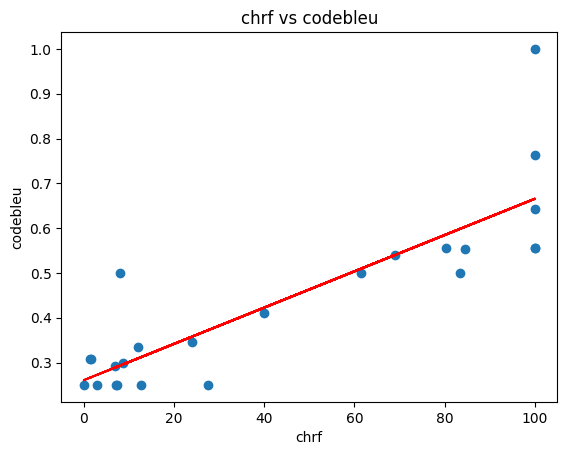

In [36]:
plt.scatter(frame['chrf'], frame['codebleu'])
plt.title('chrf vs codebleu')
plt.xlabel('chrf')
plt.ylabel('codebleu')
coeffs = np.polyfit(frame['chrf'], frame['codebleu'], 1)
m, b = coeffs

chrf_pred = m * frame['chrf'] + b
plt.plot(frame['chrf'], chrf_pred, color='red')
plt.show()

## Exploring differences
We will explore the samples with highest squared error between metric predicted by a linear model with codebleu as argument (`m=ax+b`, where `m` is approximated metric value, `x` is the value of human judgement, and `a` and `b` are numbers chosen to match the data in to minimalize mean squared error) and the true values. We will choose top 5 errors for both codebleu and chrf.
### top 5 errors in chrf

In [37]:
frame.iloc[np.argpartition(se_chrf, 5)[-5:]]

,prefix,suffix,missing,predictions,chrf,codebleu,exact_match,manual_score
13,# for speed,logging._srcfile = None,up (avoiding sys._getframe() calls)\n,in the log file\n,7.165037,0.250000,0.0,5
17,DB_,"APP_HOST = os.environ.get(""APP_HOST"")",PORT = 5432\n,"= os.environ.get(""DB_NAME"")\n",1.344086,0.308136,0.0,5
9,import,import asyncio,pytest\n,aiohttp\n,8.064516,0.500000,0.0,6
23,JOBS_ACTIVE_,NaN,"CTR = Gauge('jobs_active_total', 'Total Jobs')","= Gauge('jobs_active_total', 'Total jobs')\n",84.610343,0.553351,0.0,5
11,insert_exam,stateful_set_index = 1,ple_jobs(postgresql)\n,ert_jobs(postgresql)\n,83.524467,0.500000,0.0,3


The biggest differences were mostly caused by the samples where the human judgement assigned the too big score to the sample due to completion that seems to have semantic sense but being completely different from the target one.

### top 5 errors in codebleu

In [38]:
frame.iloc[np.argpartition(se_codebleu, 5)[-5:]]

,prefix,suffix,missing,predictions,chrf,codebleu,exact_match,manual_score
22,PINGS_SENT_CTR = Counter(,SUCCESSFUL_PINGS_CTR = Counter('successful_pin...,"'pings_sent_total', 'Total Pings')\n","'pings_sent_ctr', 'Total Pings sent')\n",69.041451,0.539349,0.0,5
23,JOBS_ACTIVE_,NaN,"CTR = Gauge('jobs_active_total', 'Total Jobs')","= Gauge('jobs_active_total', 'Total jobs')\n",84.610343,0.553351,0.0,5
13,# for speed,logging._srcfile = None,up (avoiding sys._getframe() calls)\n,in the log file\n,7.165037,0.250000,0.0,5
11,insert_exam,stateful_set_index = 1,ple_jobs(postgresql)\n,ert_jobs(postgresql)\n,83.524467,0.500000,0.0,3
8,,payload = example_payload.copy(),test_client = await aiohttp_client(setup_a...,test_client = await aiohttp_client(setup_ap...,100.000000,1.000000,0.0,10


As we see the samples are partially overlapping, which suggests the same cause of missmatch as in case of chrf. For example:<br/>
`JOBS_ACTIVE_` being completed to `= Gauge('jobs_active_total', 'Total jobs')` is not a bad completion, but the target one was `CTR = Gauge('jobs_active_total', 'Total Jobs')`.